# Abordagem Inicial 

## Objetivo 

### Propor método para:
* encontrar representações comuns de diferentes modalidades sensoriais
* aumentar a quantidade de dados utilizados para redução de dimensionalidade do sinal
* melhorar a sensibilidade de análises MVPA posteriores 

### Inicialmente codificar cada instante de tempo (sem usar janelas no tempo)
### Decodificar o momento que estava na mesma e na outra modalidade a partir do estado reduzido
* Comparar com decodificação usando: (1) Sinais originais, (2) PCA geral, (3) PCA em cada ponto, (4) Auto-encoder
### Ver sobre use da auto-encoders e VAEs
### Checar sobre predição da reprodução do intervalo temporal


In [1]:
import sys
sys.path.append("../src/data")
from myMNE import makeMNE

In [2]:
from os import listdir
from os.path import isfile, join
mypath = '../data/raw/aud/'

onlyfiles = [mypath+"/"+f for f in listdir(mypath) if isfile(join(mypath, f))]
auds = list(map(makeMNE,onlyfiles))

In [3]:
data = [aud.get_data().T for aud in auds]

import numpy as np
merge_data = np.concatenate(data)

merge_data =  merge_data.reshape((10780, 240, 64))

### EEG recordings and pre-processing

EEG was recorded continuously from 64 ActiCap Electrodes (Brain Products) at 1000 Hz by a QuickAmp amplifier (Brain Products). All sites were referenced to FCz and grounded to AFz. The electrodes were positioned according to the International 10–10 system. Additional bipolar electrodes registered the electrooculogram (EOG).

EEG pre-processing was carried out using BrainVision Analyzer (Brain Products). All data were down-sampled to 250 Hz and re-referenced to the average activity across electrodes. For eye movement artefact rejection, an independent component analysis (ICA) was performed on filtered (Butterworth Zero Phase Filter between 0.05.05 Hz and 30 Hz) and segmented (−200 to 2000 ms relative to S1) data. For the ICA, epochs were baselined based on the average activity of the entire trial. Eye related components were identified by comparing individual ICA components with EOG channels and by visual inspection. The average proportion of rejected trials for each participant corresponded to 0.0613. For all further analyses, epochs were baseline corrected based on the period between −200 ms and 0 ms relative to S1 presentation.

In [4]:
data[0].shape

(539, 64, 240)

### Passo 1: treinar com dados completos capturados do experimento
* Entrada e saída como o mesmo sinal (um número para cada eletrodo)
* Usar uma rede fully connected e auto-encoder padrão
    * 64(E) - 32 - 16 - 8 - 16 - 32 - 64(S)
    * Fazer testes verificando o erro de reconstrução
* Uma rede por voluntário e por modalidade
* Pouca quantidade de dados -> incluir regularização, como dropout, para evitar overfitting


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import losses

In [6]:
fun_loss = losses.mean_absolute_error

value_encoding_dim = 8
original_trial =  Input(shape=(240,1))
enconded = Dense(64, activation='relu')(original_trial)
enconded = Dense(32, activation='relu')(enconded)
enconded = Dense(16, activation='relu')(enconded)


enconded = Dense(value_encoding_dim, activation='relu')(enconded)
deconded = Dense(16, activation='relu', use_bias=False)(enconded)
deconded = Dense(32, activation='relu', use_bias=False)(deconded)
deconded = Dense(64, activation='relu', use_bias=False)(deconded)

encoder = Model(original_trial, enconded, name='encoder')
autoencoder = Model(original_trial, deconded, name='autoenconder')    


autoencoder.compile(optimizer='adam', loss=fun_loss,metrics = ['accuracy'])

In [7]:
canal_1 = merge_data[:,:,63]
X_exemplo = canal_1.reshape(10780, 240,1)

In [16]:
epochs = 1000
batch_size = 500

history_a = autoencoder.fit(X_exemplo, X_exemplo, 
                          epochs=epochs, 
                          batch_size=batch_size,
                          shuffle=True,validation_data=(X_exemplo,X_exemplo))

Train on 10780 samples, validate on 10780 samples
Epoch 1/1000
10780/10780 [==============================] - 0s 36us/sample - loss: 7.5115 - accuracy: 0.5013 - val_loss: 7.4981 - val_accuracy: 0.5013
Epoch 2/1000
10780/10780 [==============================] - 0s 36us/sample - loss: 7.5149 - accuracy: 0.5015 - val_loss: 7.5093 - val_accuracy: 0.5055
Epoch 3/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 7.5070 - accuracy: 0.5053 - val_loss: 7.5191 - val_accuracy: 0.5023
Epoch 4/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 7.5076 - accuracy: 0.5016 - val_loss: 7.5165 - val_accuracy: 0.5018
Epoch 5/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 7.5073 - accuracy: 0.6067 - val_loss: 7.4980 - val_accuracy: 1.0000
Epoch 6/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 7.5078 - accuracy: 0.5243 - val_loss: 7.5149 - val_accuracy: 0.5012
Epoch 7/1000
10780/10780 [==================

10780/10780 [==============================] - 0s 40us/sample - loss: 7.4960 - accuracy: 0.5012 - val_loss: 7.5000 - val_accuracy: 0.5012
Epoch 55/1000
10780/10780 [==============================] - 1s 53us/sample - loss: 7.5005 - accuracy: 0.5013 - val_loss: 7.5111 - val_accuracy: 0.5014
Epoch 56/1000
10780/10780 [==============================] - 1s 53us/sample - loss: 7.5020 - accuracy: 0.5013 - val_loss: 7.4879 - val_accuracy: 0.5013
Epoch 57/1000
10780/10780 [==============================] - 1s 52us/sample - loss: 7.4932 - accuracy: 0.5013 - val_loss: 7.5018 - val_accuracy: 0.5012
Epoch 58/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 7.5044 - accuracy: 0.5013 - val_loss: 7.4938 - val_accuracy: 0.5012
Epoch 59/1000
10780/10780 [==============================] - 0s 43us/sample - loss: 7.4949 - accuracy: 0.5934 - val_loss: 7.4970 - val_accuracy: 0.5013
Epoch 60/1000
10780/10780 [==============================] - 1s 49us/sample - loss: 7.4935 - accuracy:

Epoch 108/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 7.4223 - accuracy: 0.5711 - val_loss: 7.4514 - val_accuracy: 0.5016
Epoch 109/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 7.4124 - accuracy: 0.5012 - val_loss: 7.4110 - val_accuracy: 0.5013
Epoch 110/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 7.4102 - accuracy: 0.5012 - val_loss: 7.4072 - val_accuracy: 0.5012
Epoch 111/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 7.4105 - accuracy: 0.5012 - val_loss: 7.4167 - val_accuracy: 0.5010
Epoch 112/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.4131 - accuracy: 0.5012 - val_loss: 7.4073 - val_accuracy: 0.5013
Epoch 113/1000
10780/10780 [==============================] - 1s 47us/sample - loss: 7.4136 - accuracy: 0.5475 - val_loss: 7.4147 - val_accuracy: 0.5013
Epoch 114/1000
10780/10780 [==============================] - 1s 47us/sample - los

10780/10780 [==============================] - 0s 40us/sample - loss: 7.4200 - accuracy: 0.5013 - val_loss: 7.4049 - val_accuracy: 0.5014
Epoch 162/1000
10780/10780 [==============================] - 1s 54us/sample - loss: 7.4122 - accuracy: 0.5013 - val_loss: 7.4100 - val_accuracy: 0.5011
Epoch 163/1000
10780/10780 [==============================] - 0s 39us/sample - loss: 7.4089 - accuracy: 0.5012 - val_loss: 7.4086 - val_accuracy: 0.5013
Epoch 164/1000
10780/10780 [==============================] - 0s 43us/sample - loss: 7.4115 - accuracy: 0.5013 - val_loss: 7.4022 - val_accuracy: 0.5015
Epoch 165/1000
10780/10780 [==============================] - 0s 43us/sample - loss: 7.4083 - accuracy: 0.5013 - val_loss: 7.4160 - val_accuracy: 0.5014
Epoch 166/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.4100 - accuracy: 0.5012 - val_loss: 7.4050 - val_accuracy: 0.5011
Epoch 167/1000
10780/10780 [==============================] - 0s 43us/sample - loss: 7.4280 - acc

10780/10780 [==============================] - 0s 44us/sample - loss: 7.4121 - accuracy: 0.5525 - val_loss: 7.4103 - val_accuracy: 0.5012
Epoch 215/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 7.4116 - accuracy: 0.5013 - val_loss: 7.4117 - val_accuracy: 0.5011
Epoch 216/1000
10780/10780 [==============================] - 0s 46us/sample - loss: 7.4067 - accuracy: 0.5040 - val_loss: 7.4069 - val_accuracy: 0.5180
Epoch 217/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.4049 - accuracy: 0.5037 - val_loss: 7.4189 - val_accuracy: 0.5010
Epoch 218/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 7.4071 - accuracy: 0.5012 - val_loss: 7.3960 - val_accuracy: 0.5011
Epoch 219/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 7.4135 - accuracy: 0.5012 - val_loss: 7.4018 - val_accuracy: 0.5012
Epoch 220/1000
10780/10780 [==============================] - 1s 53us/sample - loss: 7.4078 - acc

10780/10780 [==============================] - 0s 35us/sample - loss: 7.4080 - accuracy: 0.5013 - val_loss: 7.3946 - val_accuracy: 0.5011
Epoch 268/1000
10780/10780 [==============================] - 0s 32us/sample - loss: 7.4070 - accuracy: 0.6204 - val_loss: 7.4049 - val_accuracy: 0.5011
Epoch 269/1000
10780/10780 [==============================] - 0s 39us/sample - loss: 7.4002 - accuracy: 0.5012 - val_loss: 7.4220 - val_accuracy: 0.5011
Epoch 270/1000
10780/10780 [==============================] - 0s 33us/sample - loss: 7.4088 - accuracy: 0.5013 - val_loss: 7.3996 - val_accuracy: 0.5015
Epoch 271/1000
10780/10780 [==============================] - 0s 34us/sample - loss: 7.4041 - accuracy: 0.5012 - val_loss: 7.4015 - val_accuracy: 0.5015
Epoch 272/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 7.4002 - accuracy: 0.7571 - val_loss: 7.4030 - val_accuracy: 0.9502
Epoch 273/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 7.4000 - acc

10780/10780 [==============================] - 0s 32us/sample - loss: 7.4058 - accuracy: 0.5013 - val_loss: 7.4000 - val_accuracy: 0.5014
Epoch 321/1000
10780/10780 [==============================] - 0s 33us/sample - loss: 7.4030 - accuracy: 0.5662 - val_loss: 7.4225 - val_accuracy: 0.5016
Epoch 322/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 7.4128 - accuracy: 0.5014 - val_loss: 7.4251 - val_accuracy: 0.5015
Epoch 323/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 7.4167 - accuracy: 0.5011 - val_loss: 7.4159 - val_accuracy: 0.5014
Epoch 324/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.4096 - accuracy: 0.5012 - val_loss: 7.4062 - val_accuracy: 0.5015
Epoch 325/1000
10780/10780 [==============================] - 0s 35us/sample - loss: 7.4016 - accuracy: 0.5013 - val_loss: 7.3946 - val_accuracy: 0.5013
Epoch 326/1000
10780/10780 [==============================] - 0s 39us/sample - loss: 7.4056 - acc

10780/10780 [==============================] - 1s 53us/sample - loss: 7.3913 - accuracy: 0.5232 - val_loss: 7.3966 - val_accuracy: 0.5013
Epoch 374/1000
10780/10780 [==============================] - 0s 34us/sample - loss: 7.4016 - accuracy: 0.5012 - val_loss: 7.4028 - val_accuracy: 0.5015
Epoch 375/1000
10780/10780 [==============================] - 0s 33us/sample - loss: 7.4031 - accuracy: 0.5013 - val_loss: 7.4046 - val_accuracy: 0.5011
Epoch 376/1000
10780/10780 [==============================] - 0s 35us/sample - loss: 7.4022 - accuracy: 0.5013 - val_loss: 7.3881 - val_accuracy: 0.5013
Epoch 377/1000
10780/10780 [==============================] - 0s 37us/sample - loss: 7.4055 - accuracy: 0.5013 - val_loss: 7.3996 - val_accuracy: 0.5014
Epoch 378/1000
10780/10780 [==============================] - 0s 43us/sample - loss: 7.3946 - accuracy: 0.5441 - val_loss: 7.3907 - val_accuracy: 0.5010
Epoch 379/1000
10780/10780 [==============================] - 0s 32us/sample - loss: 7.3989 - acc

10780/10780 [==============================] - 0s 40us/sample - loss: 7.3923 - accuracy: 0.5013 - val_loss: 7.3966 - val_accuracy: 0.5011
Epoch 427/1000
10780/10780 [==============================] - 0s 45us/sample - loss: 7.3910 - accuracy: 0.5917 - val_loss: 7.3900 - val_accuracy: 0.5012
Epoch 428/1000
10780/10780 [==============================] - 0s 45us/sample - loss: 7.3926 - accuracy: 0.5011 - val_loss: 7.4021 - val_accuracy: 0.5008
Epoch 429/1000
10780/10780 [==============================] - 0s 45us/sample - loss: 7.3975 - accuracy: 0.5010 - val_loss: 7.3942 - val_accuracy: 0.5012
Epoch 430/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.3933 - accuracy: 0.5441 - val_loss: 7.3934 - val_accuracy: 0.8356
Epoch 431/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 7.3930 - accuracy: 0.6386 - val_loss: 7.3949 - val_accuracy: 0.5013
Epoch 432/1000
10780/10780 [==============================] - 0s 37us/sample - loss: 7.3928 - acc

10780/10780 [==============================] - 0s 39us/sample - loss: 7.3964 - accuracy: 0.6768 - val_loss: 7.3983 - val_accuracy: 0.9455
Epoch 480/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 7.3934 - accuracy: 0.5220 - val_loss: 7.3914 - val_accuracy: 0.5012
Epoch 481/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 7.3902 - accuracy: 0.5011 - val_loss: 7.3858 - val_accuracy: 0.5012
Epoch 482/1000
10780/10780 [==============================] - 0s 45us/sample - loss: 7.3895 - accuracy: 0.5012 - val_loss: 7.3835 - val_accuracy: 0.5012
Epoch 483/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.3950 - accuracy: 0.5012 - val_loss: 7.3909 - val_accuracy: 0.5015
Epoch 484/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.3967 - accuracy: 0.5013 - val_loss: 7.3899 - val_accuracy: 0.5009
Epoch 485/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.3898 - acc

10780/10780 [==============================] - 0s 40us/sample - loss: 7.3884 - accuracy: 0.5011 - val_loss: 7.3842 - val_accuracy: 0.5007
Epoch 533/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.3936 - accuracy: 0.5009 - val_loss: 7.3844 - val_accuracy: 0.5013
Epoch 534/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 7.3963 - accuracy: 0.5010 - val_loss: 7.3981 - val_accuracy: 0.5005
Epoch 535/1000
10780/10780 [==============================] - 0s 35us/sample - loss: 7.3964 - accuracy: 0.5012 - val_loss: 7.4052 - val_accuracy: 0.5013
Epoch 536/1000
10780/10780 [==============================] - 0s 43us/sample - loss: 7.3967 - accuracy: 0.5011 - val_loss: 7.3830 - val_accuracy: 0.5012
Epoch 537/1000
10780/10780 [==============================] - 0s 37us/sample - loss: 7.3935 - accuracy: 0.5011 - val_loss: 7.3955 - val_accuracy: 0.5014
Epoch 538/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 7.4011 - acc

10780/10780 [==============================] - 0s 39us/sample - loss: 7.3937 - accuracy: 0.5013 - val_loss: 7.4003 - val_accuracy: 0.5010
Epoch 586/1000
10780/10780 [==============================] - 0s 39us/sample - loss: 7.3940 - accuracy: 0.5012 - val_loss: 7.3940 - val_accuracy: 0.5014
Epoch 587/1000
10780/10780 [==============================] - 0s 39us/sample - loss: 7.3910 - accuracy: 0.5159 - val_loss: 7.3896 - val_accuracy: 0.5013
Epoch 588/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.3871 - accuracy: 0.5013 - val_loss: 7.3889 - val_accuracy: 0.5015
Epoch 589/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 7.3834 - accuracy: 0.5011 - val_loss: 7.3813 - val_accuracy: 0.5012
Epoch 590/1000
10780/10780 [==============================] - 1s 49us/sample - loss: 7.3855 - accuracy: 0.5012 - val_loss: 7.3953 - val_accuracy: 0.5013
Epoch 591/1000
10780/10780 [==============================] - 0s 39us/sample - loss: 7.3879 - acc

10780/10780 [==============================] - 0s 39us/sample - loss: 7.3834 - accuracy: 0.5011 - val_loss: 7.3793 - val_accuracy: 0.9482
Epoch 639/1000
10780/10780 [==============================] - 0s 39us/sample - loss: 7.3870 - accuracy: 0.5911 - val_loss: 7.3878 - val_accuracy: 0.5011
Epoch 640/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 7.3911 - accuracy: 0.5013 - val_loss: 7.3808 - val_accuracy: 0.5013
Epoch 641/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.3870 - accuracy: 0.6021 - val_loss: 7.3898 - val_accuracy: 0.5011
Epoch 642/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.3864 - accuracy: 0.6091 - val_loss: 7.3899 - val_accuracy: 0.5014
Epoch 643/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 7.3870 - accuracy: 0.5013 - val_loss: 7.3871 - val_accuracy: 0.5012
Epoch 644/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.3868 - acc

10780/10780 [==============================] - 0s 37us/sample - loss: 7.3857 - accuracy: 0.5012 - val_loss: 7.3899 - val_accuracy: 0.5010
Epoch 692/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 7.3850 - accuracy: 0.5025 - val_loss: 7.3836 - val_accuracy: 0.5011
Epoch 693/1000
10780/10780 [==============================] - 0s 46us/sample - loss: 7.3852 - accuracy: 0.5012 - val_loss: 7.3864 - val_accuracy: 0.5010
Epoch 694/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 7.3854 - accuracy: 0.5012 - val_loss: 7.3840 - val_accuracy: 0.5013
Epoch 695/1000
10780/10780 [==============================] - 0s 39us/sample - loss: 7.3851 - accuracy: 0.5012 - val_loss: 7.3855 - val_accuracy: 0.5011
Epoch 696/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.3850 - accuracy: 0.5012 - val_loss: 7.3785 - val_accuracy: 0.5012
Epoch 697/1000
10780/10780 [==============================] - 0s 43us/sample - loss: 7.3805 - acc

10780/10780 [==============================] - 0s 34us/sample - loss: 7.3824 - accuracy: 0.5012 - val_loss: 7.3861 - val_accuracy: 0.5011
Epoch 745/1000
10780/10780 [==============================] - 0s 35us/sample - loss: 7.3908 - accuracy: 0.5012 - val_loss: 7.3878 - val_accuracy: 0.5012
Epoch 746/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 7.3847 - accuracy: 0.5011 - val_loss: 7.3834 - val_accuracy: 0.5015
Epoch 747/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 7.3842 - accuracy: 0.5014 - val_loss: 7.3816 - val_accuracy: 0.5013
Epoch 748/1000
10780/10780 [==============================] - 0s 37us/sample - loss: 7.3811 - accuracy: 0.5512 - val_loss: 7.3865 - val_accuracy: 0.5012
Epoch 749/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 7.3847 - accuracy: 0.5013 - val_loss: 7.3884 - val_accuracy: 0.5012
Epoch 750/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 7.3879 - acc

10780/10780 [==============================] - 0s 46us/sample - loss: 7.3815 - accuracy: 0.5012 - val_loss: 7.3856 - val_accuracy: 0.5012
Epoch 798/1000
10780/10780 [==============================] - 0s 37us/sample - loss: 7.3824 - accuracy: 0.5012 - val_loss: 7.3828 - val_accuracy: 0.5012
Epoch 799/1000
10780/10780 [==============================] - 0s 34us/sample - loss: 7.3868 - accuracy: 0.5012 - val_loss: 7.3959 - val_accuracy: 0.5011
Epoch 800/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 7.3857 - accuracy: 0.5012 - val_loss: 7.3774 - val_accuracy: 0.5012
Epoch 801/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.3843 - accuracy: 0.5012 - val_loss: 7.3807 - val_accuracy: 0.5012
Epoch 802/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 7.3829 - accuracy: 0.5012 - val_loss: 7.3785 - val_accuracy: 0.5013
Epoch 803/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 7.3815 - acc

10780/10780 [==============================] - 0s 35us/sample - loss: 7.3805 - accuracy: 0.5011 - val_loss: 7.3780 - val_accuracy: 0.5013
Epoch 851/1000
10780/10780 [==============================] - 0s 36us/sample - loss: 7.3801 - accuracy: 0.5011 - val_loss: 7.3857 - val_accuracy: 0.5011
Epoch 852/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 7.3828 - accuracy: 0.5012 - val_loss: 7.3785 - val_accuracy: 0.5012
Epoch 853/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 7.3825 - accuracy: 0.5011 - val_loss: 7.3795 - val_accuracy: 0.5013
Epoch 854/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 7.3824 - accuracy: 0.5011 - val_loss: 7.3824 - val_accuracy: 0.5012
Epoch 855/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 7.3804 - accuracy: 0.5270 - val_loss: 7.3795 - val_accuracy: 0.5011
Epoch 856/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 7.3822 - acc

10780/10780 [==============================] - 0s 33us/sample - loss: 7.3816 - accuracy: 0.5011 - val_loss: 7.3888 - val_accuracy: 0.5013
Epoch 904/1000
10780/10780 [==============================] - 0s 31us/sample - loss: 7.3851 - accuracy: 0.5012 - val_loss: 7.3810 - val_accuracy: 0.5011
Epoch 905/1000
10780/10780 [==============================] - 0s 28us/sample - loss: 7.3817 - accuracy: 0.5011 - val_loss: 7.3797 - val_accuracy: 0.5012
Epoch 906/1000
10780/10780 [==============================] - 0s 37us/sample - loss: 7.3827 - accuracy: 0.5012 - val_loss: 7.3800 - val_accuracy: 0.5011
Epoch 907/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 7.3787 - accuracy: 0.5011 - val_loss: 7.3852 - val_accuracy: 0.5012
Epoch 908/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 7.3808 - accuracy: 0.5013 - val_loss: 7.3762 - val_accuracy: 0.5011
Epoch 909/1000
10780/10780 [==============================] - 0s 33us/sample - loss: 7.3808 - acc

10780/10780 [==============================] - 0s 30us/sample - loss: 7.3784 - accuracy: 0.5629 - val_loss: 7.3766 - val_accuracy: 0.8311
Epoch 957/1000
10780/10780 [==============================] - 0s 31us/sample - loss: 7.3828 - accuracy: 0.5506 - val_loss: 7.4015 - val_accuracy: 0.5021
Epoch 958/1000
10780/10780 [==============================] - 0s 34us/sample - loss: 7.3829 - accuracy: 0.5015 - val_loss: 7.3791 - val_accuracy: 0.5011
Epoch 959/1000
10780/10780 [==============================] - 0s 34us/sample - loss: 7.3810 - accuracy: 0.5012 - val_loss: 7.3808 - val_accuracy: 0.5013
Epoch 960/1000
10780/10780 [==============================] - 0s 30us/sample - loss: 7.3836 - accuracy: 0.5012 - val_loss: 7.3804 - val_accuracy: 0.5013
Epoch 961/1000
10780/10780 [==============================] - 0s 29us/sample - loss: 7.3805 - accuracy: 0.5015 - val_loss: 7.3771 - val_accuracy: 0.5011
Epoch 962/1000
10780/10780 [==============================] - 0s 34us/sample - loss: 7.3782 - acc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


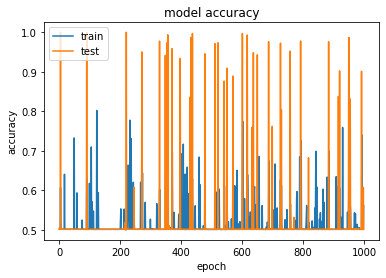

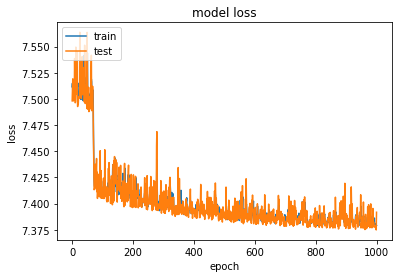

In [21]:
import matplotlib.pyplot as plt


print(history_a.history.keys())
# summarize history for accuracy
plt.plot(history_a.history['accuracy'])
plt.plot(history_a.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_a.history['loss'])
plt.plot(history_a.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



## Com regularização 

In [22]:
from tensorflow.keras import regularizers

In [23]:
fun_loss = losses.mean_absolute_error

value_encoding_dim = 8
original_trial =  Input(shape=(240,1))
enconded = Dense(64, activation='relu')(original_trial)
enconded = Dense(32, activation='relu')(enconded)
enconded = Dense(16, activation='relu')(enconded)


enconded = Dense(value_encoding_dim, activation='relu',  activity_regularizer=regularizers.l1(10e-5)
                )(enconded)
deconded = Dense(16, activation='relu', use_bias=False)(enconded)
deconded = Dense(32, activation='relu', use_bias=False)(deconded)
deconded = Dense(64, activation='relu', use_bias=False)(deconded)

encoder = Model(original_trial, enconded, name='encoder')
autoencoder = Model(original_trial, deconded, name='autoenconder')    


autoencoder.compile(optimizer='adam', loss=fun_loss,metrics = ['accuracy'])

In [24]:
epochs = 1000
batch_size = 500

history = autoencoder.fit(X_exemplo,X_exemplo, epochs=epochs, batch_size=batch_size,shuffle=True,validation_data=(X_exemplo,X_exemplo))

Train on 10780 samples, validate on 10780 samples
Epoch 1/1000
10780/10780 [==============================] - 1s 89us/sample - loss: 10.2421 - accuracy: 0.0000e+00 - val_loss: 9.9827 - val_accuracy: 0.0018
Epoch 2/1000
10780/10780 [==============================] - 0s 37us/sample - loss: 9.3067 - accuracy: 0.0948 - val_loss: 8.0920 - val_accuracy: 0.3766
Epoch 3/1000
10780/10780 [==============================] - 0s 39us/sample - loss: 7.7511 - accuracy: 0.4367 - val_loss: 7.3770 - val_accuracy: 0.4815
Epoch 4/1000
10780/10780 [==============================] - 0s 37us/sample - loss: 7.2648 - accuracy: 0.4656 - val_loss: 7.1761 - val_accuracy: 0.4656
Epoch 5/1000
10780/10780 [==============================] - 0s 35us/sample - loss: 7.1456 - accuracy: 0.4804 - val_loss: 7.1250 - val_accuracy: 0.4846
Epoch 6/1000
10780/10780 [==============================] - 0s 39us/sample - loss: 7.1091 - accuracy: 0.4866 - val_loss: 7.0964 - val_accuracy: 0.4904
Epoch 7/1000
10780/10780 [=============

10780/10780 [==============================] - 0s 44us/sample - loss: 6.9219 - accuracy: 0.5556 - val_loss: 6.9217 - val_accuracy: 0.7277
Epoch 55/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.9137 - accuracy: 0.5837 - val_loss: 6.9086 - val_accuracy: 0.5011
Epoch 56/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.9107 - accuracy: 0.5012 - val_loss: 6.9083 - val_accuracy: 0.5012
Epoch 57/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 6.9108 - accuracy: 0.5124 - val_loss: 6.9060 - val_accuracy: 0.5012
Epoch 58/1000
10780/10780 [==============================] - 0s 37us/sample - loss: 6.9051 - accuracy: 0.5498 - val_loss: 6.9042 - val_accuracy: 0.5012
Epoch 59/1000
10780/10780 [==============================] - 1s 53us/sample - loss: 6.9086 - accuracy: 0.5163 - val_loss: 6.9133 - val_accuracy: 0.5012
Epoch 60/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.9114 - accuracy:

Epoch 108/1000
10780/10780 [==============================] - 1s 49us/sample - loss: 6.8659 - accuracy: 0.5012 - val_loss: 6.8658 - val_accuracy: 0.5012
Epoch 109/1000
10780/10780 [==============================] - 1s 49us/sample - loss: 6.8699 - accuracy: 0.5012 - val_loss: 6.8828 - val_accuracy: 0.5012
Epoch 110/1000
10780/10780 [==============================] - 1s 49us/sample - loss: 6.8782 - accuracy: 0.5012 - val_loss: 6.8894 - val_accuracy: 0.5013
Epoch 111/1000
10780/10780 [==============================] - 1s 49us/sample - loss: 6.8821 - accuracy: 0.5012 - val_loss: 6.8664 - val_accuracy: 0.5011
Epoch 112/1000
10780/10780 [==============================] - 1s 49us/sample - loss: 6.8773 - accuracy: 0.5012 - val_loss: 6.8677 - val_accuracy: 0.5013
Epoch 113/1000
10780/10780 [==============================] - 1s 49us/sample - loss: 6.8749 - accuracy: 0.5011 - val_loss: 6.8750 - val_accuracy: 0.5011
Epoch 114/1000
10780/10780 [==============================] - 1s 49us/sample - los

10780/10780 [==============================] - 0s 38us/sample - loss: 6.8608 - accuracy: 0.5012 - val_loss: 6.8562 - val_accuracy: 0.5011
Epoch 162/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 6.8668 - accuracy: 0.5012 - val_loss: 6.8704 - val_accuracy: 0.5013
Epoch 163/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 6.8688 - accuracy: 0.5012 - val_loss: 6.8629 - val_accuracy: 0.5010
Epoch 164/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 6.8706 - accuracy: 0.5011 - val_loss: 6.8717 - val_accuracy: 0.5011
Epoch 165/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 6.8639 - accuracy: 0.5012 - val_loss: 6.8694 - val_accuracy: 0.5012
Epoch 166/1000
10780/10780 [==============================] - 0s 43us/sample - loss: 6.8589 - accuracy: 0.5011 - val_loss: 6.8527 - val_accuracy: 0.5012
Epoch 167/1000
10780/10780 [==============================] - 1s 49us/sample - loss: 6.8574 - acc

10780/10780 [==============================] - 0s 43us/sample - loss: 6.8595 - accuracy: 0.5012 - val_loss: 6.8581 - val_accuracy: 0.5011
Epoch 215/1000
10780/10780 [==============================] - 1s 53us/sample - loss: 6.8496 - accuracy: 0.5012 - val_loss: 6.8461 - val_accuracy: 0.5013
Epoch 216/1000
10780/10780 [==============================] - 1s 54us/sample - loss: 6.8523 - accuracy: 0.5012 - val_loss: 6.8521 - val_accuracy: 0.5012
Epoch 217/1000
10780/10780 [==============================] - 1s 53us/sample - loss: 6.8522 - accuracy: 0.5012 - val_loss: 6.8484 - val_accuracy: 0.5013
Epoch 218/1000
10780/10780 [==============================] - 1s 52us/sample - loss: 6.8521 - accuracy: 0.5012 - val_loss: 6.8483 - val_accuracy: 0.5012
Epoch 219/1000
10780/10780 [==============================] - 1s 53us/sample - loss: 6.8524 - accuracy: 0.5243 - val_loss: 6.8491 - val_accuracy: 0.5012
Epoch 220/1000
10780/10780 [==============================] - 1s 53us/sample - loss: 6.8522 - acc

10780/10780 [==============================] - 0s 40us/sample - loss: 6.8498 - accuracy: 0.5240 - val_loss: 6.8469 - val_accuracy: 0.5013
Epoch 268/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8578 - accuracy: 0.5012 - val_loss: 6.8575 - val_accuracy: 0.5013
Epoch 269/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8576 - accuracy: 0.5012 - val_loss: 6.8610 - val_accuracy: 0.5011
Epoch 270/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8482 - accuracy: 0.5012 - val_loss: 6.8431 - val_accuracy: 0.5011
Epoch 271/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8432 - accuracy: 0.5012 - val_loss: 6.8392 - val_accuracy: 0.5012
Epoch 272/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8466 - accuracy: 0.6857 - val_loss: 6.8403 - val_accuracy: 0.5011
Epoch 273/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8472 - acc

10780/10780 [==============================] - 0s 44us/sample - loss: 6.8395 - accuracy: 0.5012 - val_loss: 6.8352 - val_accuracy: 0.5012
Epoch 321/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8432 - accuracy: 0.5012 - val_loss: 6.8432 - val_accuracy: 0.5013
Epoch 322/1000
10780/10780 [==============================] - 0s 45us/sample - loss: 6.8429 - accuracy: 0.5012 - val_loss: 6.8418 - val_accuracy: 0.5011
Epoch 323/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8432 - accuracy: 0.5012 - val_loss: 6.8487 - val_accuracy: 0.5012
Epoch 324/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8420 - accuracy: 0.5012 - val_loss: 6.8440 - val_accuracy: 0.5011
Epoch 325/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8483 - accuracy: 0.5012 - val_loss: 6.8468 - val_accuracy: 0.5012
Epoch 326/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8423 - acc

10780/10780 [==============================] - 1s 48us/sample - loss: 6.8434 - accuracy: 0.5012 - val_loss: 6.8354 - val_accuracy: 0.5011
Epoch 374/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 6.8405 - accuracy: 0.5934 - val_loss: 6.8375 - val_accuracy: 0.5011
Epoch 375/1000
10780/10780 [==============================] - 1s 49us/sample - loss: 6.8365 - accuracy: 0.5011 - val_loss: 6.8328 - val_accuracy: 0.5012
Epoch 376/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 6.8342 - accuracy: 0.5012 - val_loss: 6.8439 - val_accuracy: 0.5012
Epoch 377/1000
10780/10780 [==============================] - 1s 47us/sample - loss: 6.8385 - accuracy: 0.5012 - val_loss: 6.8393 - val_accuracy: 0.5012
Epoch 378/1000
10780/10780 [==============================] - 1s 52us/sample - loss: 6.8378 - accuracy: 0.5012 - val_loss: 6.8513 - val_accuracy: 0.5012
Epoch 379/1000
10780/10780 [==============================] - 1s 52us/sample - loss: 6.8493 - acc

10780/10780 [==============================] - 0s 41us/sample - loss: 6.8323 - accuracy: 0.5012 - val_loss: 6.8419 - val_accuracy: 0.5011
Epoch 427/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8376 - accuracy: 0.5012 - val_loss: 6.8343 - val_accuracy: 0.5012
Epoch 428/1000
10780/10780 [==============================] - 0s 43us/sample - loss: 6.8364 - accuracy: 0.5012 - val_loss: 6.8416 - val_accuracy: 0.5012
Epoch 429/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 6.8366 - accuracy: 0.5012 - val_loss: 6.8462 - val_accuracy: 0.5012
Epoch 430/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 6.8492 - accuracy: 0.5012 - val_loss: 6.8529 - val_accuracy: 0.5011
Epoch 431/1000
10780/10780 [==============================] - 0s 46us/sample - loss: 6.8460 - accuracy: 0.4944 - val_loss: 6.8408 - val_accuracy: 0.5007
Epoch 432/1000
10780/10780 [==============================] - 0s 46us/sample - loss: 6.8365 - acc

10780/10780 [==============================] - 1s 47us/sample - loss: 6.8304 - accuracy: 0.5013 - val_loss: 6.8434 - val_accuracy: 0.5012
Epoch 480/1000
10780/10780 [==============================] - 1s 47us/sample - loss: 6.8349 - accuracy: 0.6861 - val_loss: 6.8321 - val_accuracy: 0.5012
Epoch 481/1000
10780/10780 [==============================] - 1s 47us/sample - loss: 6.8343 - accuracy: 0.5013 - val_loss: 6.8338 - val_accuracy: 0.5012
Epoch 482/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 6.8344 - accuracy: 0.5835 - val_loss: 6.8275 - val_accuracy: 0.5014
Epoch 483/1000
10780/10780 [==============================] - 0s 45us/sample - loss: 6.8313 - accuracy: 0.5013 - val_loss: 6.8278 - val_accuracy: 0.5013
Epoch 484/1000
10780/10780 [==============================] - 0s 45us/sample - loss: 6.8306 - accuracy: 0.5013 - val_loss: 6.8348 - val_accuracy: 1.0000
Epoch 485/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8343 - acc

10780/10780 [==============================] - 0s 36us/sample - loss: 6.8355 - accuracy: 0.5013 - val_loss: 6.8296 - val_accuracy: 0.5012
Epoch 533/1000
10780/10780 [==============================] - 0s 42us/sample - loss: 6.8317 - accuracy: 0.5013 - val_loss: 6.8302 - val_accuracy: 0.5012
Epoch 534/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8318 - accuracy: 0.5013 - val_loss: 6.8323 - val_accuracy: 0.5012
Epoch 535/1000
10780/10780 [==============================] - 0s 43us/sample - loss: 6.8273 - accuracy: 0.5012 - val_loss: 6.8294 - val_accuracy: 0.5013
Epoch 536/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 6.8301 - accuracy: 0.6626 - val_loss: 6.8344 - val_accuracy: 0.5015
Epoch 537/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 6.8392 - accuracy: 0.5013 - val_loss: 6.8321 - val_accuracy: 0.5013
Epoch 538/1000
10780/10780 [==============================] - 0s 34us/sample - loss: 6.8332 - acc

10780/10780 [==============================] - 0s 33us/sample - loss: 6.8398 - accuracy: 0.7557 - val_loss: 6.8237 - val_accuracy: 0.5013
Epoch 586/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 6.8316 - accuracy: 0.5013 - val_loss: 6.8263 - val_accuracy: 0.5012
Epoch 587/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 6.8305 - accuracy: 0.5012 - val_loss: 6.8323 - val_accuracy: 0.5013
Epoch 588/1000
10780/10780 [==============================] - 0s 32us/sample - loss: 6.8313 - accuracy: 0.5012 - val_loss: 6.8345 - val_accuracy: 0.5014
Epoch 589/1000
10780/10780 [==============================] - 0s 29us/sample - loss: 6.8280 - accuracy: 0.5013 - val_loss: 6.8228 - val_accuracy: 0.5012
Epoch 590/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 6.8323 - accuracy: 0.5013 - val_loss: 6.8289 - val_accuracy: 0.5011
Epoch 591/1000
10780/10780 [==============================] - 0s 37us/sample - loss: 6.8316 - acc

10780/10780 [==============================] - 0s 45us/sample - loss: 6.8265 - accuracy: 0.5012 - val_loss: 6.8312 - val_accuracy: 0.5011
Epoch 639/1000
10780/10780 [==============================] - 1s 52us/sample - loss: 6.8290 - accuracy: 0.5013 - val_loss: 6.8424 - val_accuracy: 0.5010
Epoch 640/1000
10780/10780 [==============================] - 1s 53us/sample - loss: 6.8392 - accuracy: 0.5013 - val_loss: 6.8287 - val_accuracy: 0.5011
Epoch 641/1000
10780/10780 [==============================] - 0s 46us/sample - loss: 6.8319 - accuracy: 0.5941 - val_loss: 6.8247 - val_accuracy: 0.5014
Epoch 642/1000
10780/10780 [==============================] - 0s 36us/sample - loss: 6.8233 - accuracy: 0.5478 - val_loss: 6.8206 - val_accuracy: 0.5013
Epoch 643/1000
10780/10780 [==============================] - 0s 31us/sample - loss: 6.8241 - accuracy: 0.5013 - val_loss: 6.8222 - val_accuracy: 0.5012
Epoch 644/1000
10780/10780 [==============================] - 0s 32us/sample - loss: 6.8266 - acc

10780/10780 [==============================] - 0s 37us/sample - loss: 6.8279 - accuracy: 0.5013 - val_loss: 6.8327 - val_accuracy: 0.5011
Epoch 692/1000
10780/10780 [==============================] - 0s 36us/sample - loss: 6.8282 - accuracy: 0.5012 - val_loss: 6.8233 - val_accuracy: 0.5013
Epoch 693/1000
10780/10780 [==============================] - 0s 37us/sample - loss: 6.8245 - accuracy: 0.5013 - val_loss: 6.8231 - val_accuracy: 0.5010
Epoch 694/1000
10780/10780 [==============================] - 0s 34us/sample - loss: 6.8282 - accuracy: 0.5013 - val_loss: 6.8221 - val_accuracy: 0.5013
Epoch 695/1000
10780/10780 [==============================] - 0s 36us/sample - loss: 6.8268 - accuracy: 0.5013 - val_loss: 6.8348 - val_accuracy: 0.5012
Epoch 696/1000
10780/10780 [==============================] - 0s 45us/sample - loss: 6.8321 - accuracy: 0.5013 - val_loss: 6.8273 - val_accuracy: 0.5012
Epoch 697/1000
10780/10780 [==============================] - 0s 46us/sample - loss: 6.8327 - acc

10780/10780 [==============================] - 0s 43us/sample - loss: 6.8215 - accuracy: 0.5245 - val_loss: 6.8318 - val_accuracy: 0.5013
Epoch 745/1000
10780/10780 [==============================] - 0s 33us/sample - loss: 6.8275 - accuracy: 0.5013 - val_loss: 6.8274 - val_accuracy: 0.5012
Epoch 746/1000
10780/10780 [==============================] - 0s 33us/sample - loss: 6.8314 - accuracy: 0.5013 - val_loss: 6.8315 - val_accuracy: 0.5012
Epoch 747/1000
10780/10780 [==============================] - 0s 36us/sample - loss: 6.8318 - accuracy: 0.5013 - val_loss: 6.8257 - val_accuracy: 0.5012
Epoch 748/1000
10780/10780 [==============================] - 0s 45us/sample - loss: 6.8356 - accuracy: 0.5013 - val_loss: 6.8358 - val_accuracy: 0.5013
Epoch 749/1000
10780/10780 [==============================] - 0s 37us/sample - loss: 6.8301 - accuracy: 0.5012 - val_loss: 6.8420 - val_accuracy: 0.5013
Epoch 750/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 6.8284 - acc

10780/10780 [==============================] - 0s 33us/sample - loss: 6.8337 - accuracy: 0.5013 - val_loss: 6.8326 - val_accuracy: 0.5016
Epoch 798/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 6.8348 - accuracy: 0.5013 - val_loss: 6.8339 - val_accuracy: 0.5011
Epoch 799/1000
10780/10780 [==============================] - 0s 45us/sample - loss: 6.8334 - accuracy: 0.5012 - val_loss: 6.8215 - val_accuracy: 0.5011
Epoch 800/1000
10780/10780 [==============================] - 0s 44us/sample - loss: 6.8297 - accuracy: 0.5013 - val_loss: 6.8204 - val_accuracy: 0.5013
Epoch 801/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 6.8243 - accuracy: 0.6999 - val_loss: 6.8365 - val_accuracy: 1.0000
Epoch 802/1000
10780/10780 [==============================] - 0s 39us/sample - loss: 6.8302 - accuracy: 0.6763 - val_loss: 6.8300 - val_accuracy: 1.0000
Epoch 803/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 6.8394 - acc

10780/10780 [==============================] - 0s 44us/sample - loss: 6.8250 - accuracy: 0.5014 - val_loss: 6.8280 - val_accuracy: 0.5011
Epoch 851/1000
10780/10780 [==============================] - 0s 40us/sample - loss: 6.8335 - accuracy: 0.5013 - val_loss: 6.8472 - val_accuracy: 0.5010
Epoch 852/1000
10780/10780 [==============================] - 0s 46us/sample - loss: 6.8308 - accuracy: 0.5013 - val_loss: 6.8380 - val_accuracy: 0.5016
Epoch 853/1000
10780/10780 [==============================] - 0s 45us/sample - loss: 6.8334 - accuracy: 0.5014 - val_loss: 6.8371 - val_accuracy: 0.5015
Epoch 854/1000
10780/10780 [==============================] - 0s 46us/sample - loss: 6.8257 - accuracy: 0.5012 - val_loss: 6.8307 - val_accuracy: 0.5015
Epoch 855/1000
10780/10780 [==============================] - 0s 43us/sample - loss: 6.8249 - accuracy: 0.5013 - val_loss: 6.8241 - val_accuracy: 0.5012
Epoch 856/1000
10780/10780 [==============================] - 0s 41us/sample - loss: 6.8218 - acc

10780/10780 [==============================] - 1s 48us/sample - loss: 6.8233 - accuracy: 0.5012 - val_loss: 6.8213 - val_accuracy: 0.5014
Epoch 904/1000
10780/10780 [==============================] - 1s 48us/sample - loss: 6.8200 - accuracy: 0.5013 - val_loss: 6.8162 - val_accuracy: 0.5013
Epoch 905/1000
10780/10780 [==============================] - 1s 54us/sample - loss: 6.8216 - accuracy: 0.5013 - val_loss: 6.8274 - val_accuracy: 0.5014
Epoch 906/1000
10780/10780 [==============================] - 1s 57us/sample - loss: 6.8249 - accuracy: 0.5013 - val_loss: 6.8298 - val_accuracy: 0.5014
Epoch 907/1000
10780/10780 [==============================] - 1s 57us/sample - loss: 6.8317 - accuracy: 0.5013 - val_loss: 6.8349 - val_accuracy: 0.5011
Epoch 908/1000
10780/10780 [==============================] - 1s 57us/sample - loss: 6.8288 - accuracy: 0.5013 - val_loss: 6.8205 - val_accuracy: 0.5013
Epoch 909/1000
10780/10780 [==============================] - 1s 54us/sample - loss: 6.8195 - acc

10780/10780 [==============================] - 0s 40us/sample - loss: 6.8245 - accuracy: 0.5013 - val_loss: 6.8354 - val_accuracy: 0.5015
Epoch 957/1000
10780/10780 [==============================] - 0s 35us/sample - loss: 6.8292 - accuracy: 0.5013 - val_loss: 6.8260 - val_accuracy: 0.5014
Epoch 958/1000
10780/10780 [==============================] - 0s 35us/sample - loss: 6.8224 - accuracy: 0.5013 - val_loss: 6.8224 - val_accuracy: 0.5012
Epoch 959/1000
10780/10780 [==============================] - 0s 36us/sample - loss: 6.8260 - accuracy: 0.5013 - val_loss: 6.8248 - val_accuracy: 0.5012
Epoch 960/1000
10780/10780 [==============================] - 0s 36us/sample - loss: 6.8221 - accuracy: 0.5013 - val_loss: 6.8314 - val_accuracy: 1.0000
Epoch 961/1000
10780/10780 [==============================] - 0s 39us/sample - loss: 6.8214 - accuracy: 0.7226 - val_loss: 6.8254 - val_accuracy: 1.0000
Epoch 962/1000
10780/10780 [==============================] - 0s 38us/sample - loss: 6.8217 - acc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


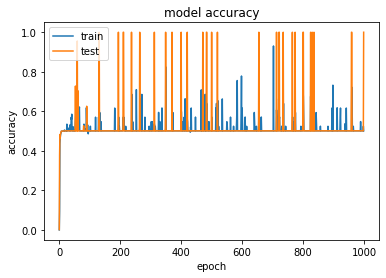

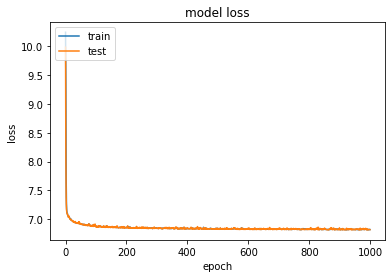

In [25]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [29]:
X_exemplo_2 =  merge_data.reshape(10780*64,240,1)

(689920, 240)

In [ ]:
epochs = 100
batch_size = 500

history = autoencoder.fit(X_exemplo_2,X_exemplo_2, epochs=epochs, 
                          batch_size=batch_size,shuffle=True,
                          validation_data=(X_exemplo_2,X_exemplo_2))

Train on 689920 samples, validate on 689920 samples
Epoch 1/100
689920/689920 [==============================] - 27s 39us/sample - loss: 6.7885 - accuracy: 0.5085 - val_loss: 6.7982 - val_accuracy: 1.0000
Epoch 2/100
689920/689920 [==============================] - 29s 42us/sample - loss: 6.7892 - accuracy: 0.5252 - val_loss: 6.7843 - val_accuracy: 0.5015
Epoch 3/100
689920/689920 [==============================] - 26s 38us/sample - loss: 6.7856 - accuracy: 0.5125 - val_loss: 6.7967 - val_accuracy: 0.5013
Epoch 4/100
689920/689920 [==============================] - 25s 36us/sample - loss: 6.7852 - accuracy: 0.5074 - val_loss: 6.7858 - val_accuracy: 0.5014
Epoch 5/100
689920/689920 [==============================] - 28s 41us/sample - loss: 6.7861 - accuracy: 0.5113 - val_loss: 6.7888 - val_accuracy: 0.5010
Epoch 6/100
689920/689920 [==============================] - 26s 37us/sample - loss: 6.7857 - accuracy: 0.5114 - val_loss: 6.7774 - val_accuracy: 0.5013
Epoch 7/100
689920/689920 [===

Epoch 54/100
689920/689920 [==============================] - 28s 40us/sample - loss: 6.7730 - accuracy: 0.5230 - val_loss: 6.7721 - val_accuracy: 0.5014
Epoch 55/100
689920/689920 [==============================] - 28s 40us/sample - loss: 6.7729 - accuracy: 0.5148 - val_loss: 6.7900 - val_accuracy: 0.5013
Epoch 56/100
689920/689920 [==============================] - 20s 29us/sample - loss: 6.7738 - accuracy: 0.5223 - val_loss: 6.7738 - val_accuracy: 0.5012
Epoch 57/100
689920/689920 [==============================] - 26s 37us/sample - loss: 6.7718 - accuracy: 0.5169 - val_loss: 6.7700 - val_accuracy: 0.5013
Epoch 58/100
689000/689920 [============================>.] - ETA: 0s - loss: 6.7735 - accuracy: 0.5158

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()




### Passo 2: gerar uma representação comum entre ambas as modalidades
* Treinar com a mesma rede para visual e auditivo
* Objetivo é verificar se gera uma melhor representação comum entre as modalidades
* Comparar o desempenho com a rede treinada em apenas uma modalidade
* Treinar redes separadas para visual e auditivo, compartilhando a parte da codificação
* Treinamento com exemplos de ambas as modalidades
* Pode ser mais interessante, pois enfatiza uma codificação comum, mas permite diferenciações na decodificação

### Passo 3: obter representações comuns entre sujeitos
* Treinar a mesma rede para todos os participantes 
* Objetivo é gerar as codificações a partir de grandes quantidades de dados
* Abordagem 1: Fazer para a rede uma rede codificação/decodificação comum a todos
    * Depois pode ser afinada para cada participante individualmente
* Abordagem 2: Usar apenas a parte de codificação em comum
    * Enfatiza uma codificação comum, mas permite diferenciações na decodificação
* Neste caso o classificador poderia ser comum também?

Passo 4: capturar informação temporal (opcional)
Repetir os passos anteriores, mas usando 5 valores para cada eletrodo (1 a cada 25 ms)
Objetivo é verificar se mais detalhes temporais melhoram a representação do tempo
Inicialmente utilizar uma arquitetura fully connected 
320(E) - 160 - 80 - 40 - 80 - 160 - 320(S)
Outra possibilidade é colocar alguma estrutura
Transformação é inicialmente realizada sobre a série temporal de cada eletrodo
Poderia também juntar sinais de eletrodos vizinhos
Isso permitiria diminuir o número de conexões